In [2]:
#setting up the required libraries 
import matplotlib.pyplot as plt
import numpy as np

# import Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy

# import plot tools
from qiskit.visualization import plot_histogram

In [62]:
#creating the oracle to mark the wanted state 110 for our case

#intializing the circuit
qcoracle = QuantumCircuit(3)
#adding the gates
qcoracle.x(0)
qcoracle.h(2)
qcoracle.ccx(0,1,2)
qcoracle.x(0)
qcoracle.h(2)
# our goal was to create a circuit that give a specific state a phase. this should in priciple use controled-z gate
#however as we are dealing with three quibit and qiskit have no ccz gate (as far as i know) we use the ccx gate and braket the x gate with haddamards such that it gives an x 
#then as we want not the state 111 but 110 we add a x gate for the 0 location quibit such that 111 don't get marked but 110

oracle = qcoracle.to_gate()
oracle.name = "U$_\omega$"
qcoracle.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_1: ───────■───────
     ┌───┐┌─┴─┐┌───┐
q_2: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘

In [63]:

#create the diffuser 

#the goal of this fi=unction is to apply the opperation of reflection of around |s> 
#which is (for the output of the oracle) we gives the states othrogonal to |s> a negative phase. 

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # we first go to |000...> basis by applying haddamards to all quibits
    

    for qubit in range(nqubits):
        qc.h(qubit)
    
    #next we add - phase to all states but 000...
    
    
    #we do this with multi-controlled-Z gate that targets the state 111...
    #we apply x gates to make 000.... 1111...
    
    for qubit in range(nqubits):
        qc.x(qubit)
    
    
    # apply the multi control z as in oracle 
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    
    #make 111... to 0000... back where now the 00... state has a negative relative phase to all other states
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # go from 000.. to s again where now we have done the reflection
    for qubit in range(nqubits):
        qc.h(qubit)
    
    #making this a qiskit gate
    U_d = qc.to_gate()
    U_d.name = "U$_d$"
    return U_d

    

In [64]:
# prepera the superposition state 
def prepare(qc, qubits):
    #apply haddamars 
    for q in qubits:
        qc.h(q)
    return qc

In [95]:
# compine the thre parts 
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = prepare(grover_circuit,  np.arange(n))
for i in range(2):
    #repeating the Amplitude amplification 
    grover_circuit.append(oracle, range(0, n))
    grover_circuit.append(diffuser(n),range(0, n))

    
grover_circuit.measure_all()
#grover_circuit.draw('mpl')




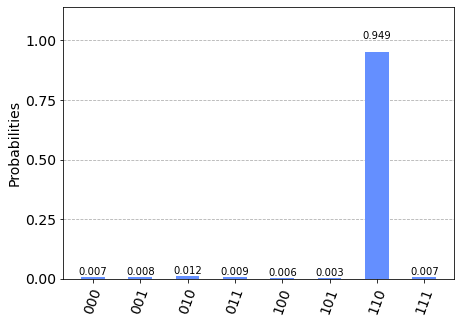

In [96]:
# using Aer qasm_simulator to simulate the results of the circle 
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [81]:
#for bonus if possible

#creating the oracle to mark any wanted state generalizing method in first oracle
def gen_oracle(nqubits, target):
#target is "location of the zero in the string example "1101" will be 2"")
#could be more than one zero ex "100" one should give target a list [1 ,2]   
   
    #intializing the circuit
               
    quan_circ = QuantumCircuit(nqubits)
    #adding the gates
    t= list(np.asarray(target) - 1)
    for i in t:
        quan_circ.x(i)


    # apply the multi control z as in oracle 
    quan_circ.h(nqubits-1)
    quan_circ.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    quan_circ.h(nqubits-1)

    #x 
    for i in t:
        quan_circ.x(i)

    oracle=quan_circ.to_gate()
    oracle.name = "U$_\omega$"
    return oracle
    #quan_circ.draw()

In [88]:

#example for 3 quibits trying to find a choosen randomly element item 
oracle9=gen_oracle(3,[1,2])

n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = prepare(grover_circuit,  np.arange(n))
for i in range(2):
    #repeating the Amplitude amplification 
    grover_circuit.append(oracle9, range(0, n))
    grover_circuit.append(diffuser(n),range(0, n))

    
grover_circuit.measure_all()
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

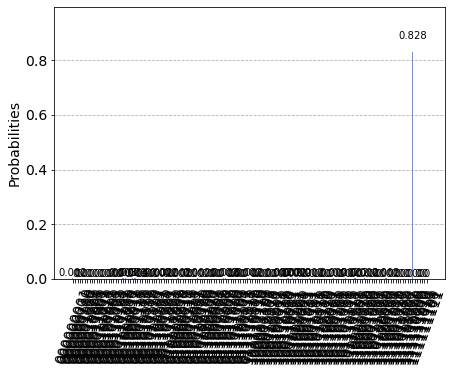

In [90]:

#example for 9 quibits trying to find a choosen randomly element item 
oracle9=gen_oracle(9,[1,3,4,2])

n = 9
grover_circuit = QuantumCircuit(n)
grover_circuit = prepare(grover_circuit,  np.arange(n))
for i in range(22):
    #repeating the Amplitude amplification 
    grover_circuit.append(oracle9, range(0, n))
    grover_circuit.append(diffuser(n),range(0, n))

    
grover_circuit.measure_all()
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [70]:
import math
math.sqrt(2**9)

22.627416997969522